In [1]:
import pandas as pd 
import os
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
import sklearn.gaussian_process as gp
import time
import pyts.approximation
import pickle
import gpflow
import tensorflow as tf

# Suppress pandas warning
pd.options.mode.chained_assignment = None

# Data directory
dir_parent = os.path.dirname(os.path.dirname(os.getcwd()))
dir_data = os.path.join(dir_parent, 'WearableData', 'GPR', 'CGM', 'Healthy')
dir_cgmfile= os.path.join(dir_data, 'CGM_healthy.csv')
dir_patientfile= os.path.join(dir_data, 'patient_info.csv')

# Read the record
cgm_all = pd.read_csv(dir_cgmfile, sep = '\t') 
patient_info = pd.read_csv(dir_patientfile, sep = ',') 
print('Finished!')

Finished!


# Explore and preporcess the data

In [2]:
# Display CGM data
cgm_all.head()

,DisplayTime,GlucoseValue,subjectId,InternalTime
0,2014-02-03 03:42:12,93,1636-69-001,2016-02-03 00:05:23
1,2014-02-03 03:47:12,93,1636-69-001,2016-02-03 00:10:23
2,2014-02-03 03:52:12,93,1636-69-001,2016-02-03 00:15:23
3,2014-02-03 03:57:12,95,1636-69-001,2016-02-03 00:20:23
4,2014-02-03 04:02:12,96,1636-69-001,2016-02-03 00:25:23


In [3]:
# Remove non-number rows on Glucose column
cgm_all.drop(cgm_all[cgm_all['GlucoseValue'] == 'Low'].index, inplace = True)

In [4]:
# Get list of subjectID
subjId_all = cgm_all['subjectId'].unique()

# Extract the data into dict of np array
glucose_dict = {}
min_duration = 60 * 24 *7 # minute
for subject in subjId_all:
    timestamp_pd = pd.to_datetime(cgm_all.loc[cgm_all['subjectId']==subject, ['DisplayTime']].stack())
    timestamp = timestamp_pd.to_numpy().astype('datetime64[s]')
    glucose_value = np.squeeze(cgm_all.loc[cgm_all['subjectId']==subject, ['GlucoseValue']].astype('float').to_numpy())
    glucose_dict[subject] = {}
    glucose_dict[subject]['timestamp'] = timestamp
    glucose_dict[subject]['glucose_value'] = glucose_value
    
    # Convert the timestamp to float (min) so GP model can work
    # also normalize the timestamp so that the time series start at day 0 but keep the hour the same
    reference_epoch = np.datetime64(pd.to_datetime(timestamp[0]).date())
    timestamp_norm = (timestamp - reference_epoch).astype('float')
    timestamp_norm = timestamp_norm / 60
    glucose_dict[subject]['timestamp_norm'] = timestamp_norm
    
    # Save the minimum duration
    if timestamp_norm[-1] < min_duration:
        min_duration = timestamp_norm[-1]

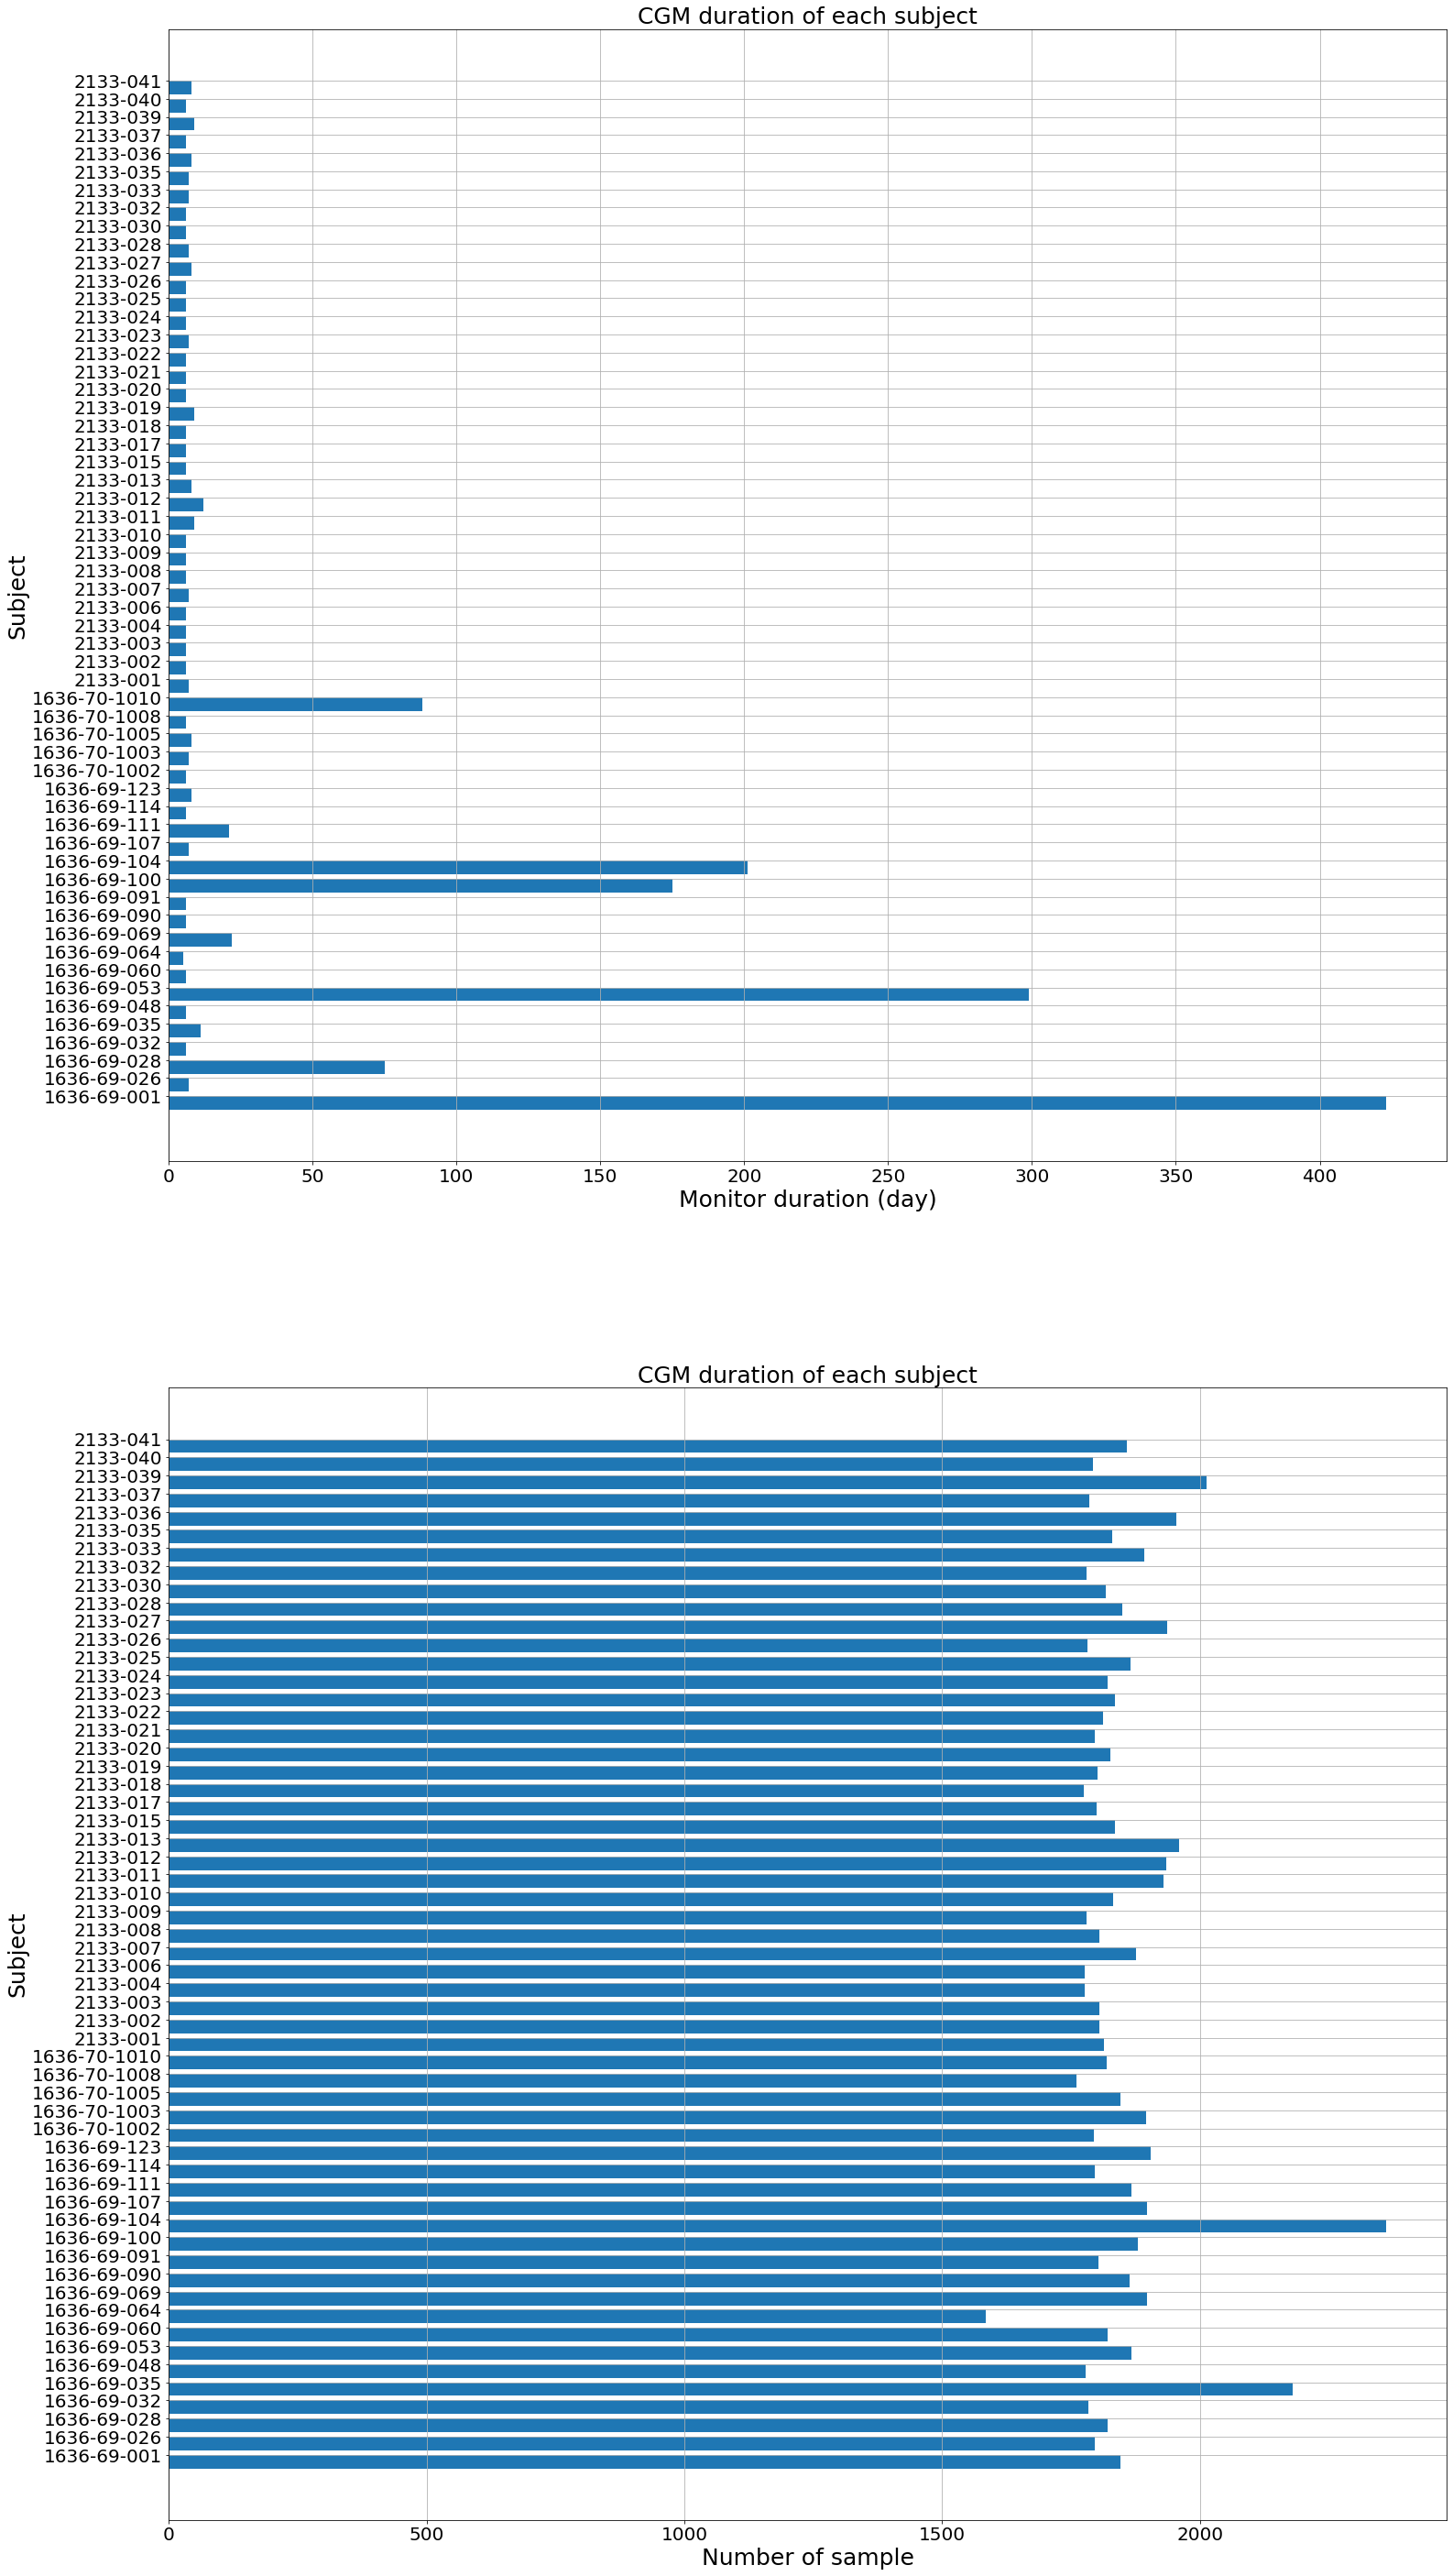

In [5]:
# Plot number of data points and recordng duration for each subject
duration_day = []
n_sample = []
for subject in subjId_all:
    glucose_subj_test = glucose_dict[subject]
    timestamp = glucose_subj_test['timestamp']
    n_sample.append(len(timestamp))
    duration = timestamp[-1] - timestamp[0]
    duration_day.append(duration.astype('timedelta64[D]').astype('int'))
    
font_size = 25
fig = plt.figure(figsize=(25, 50))

ax = fig.add_subplot(2, 1, 1)
width = 0.75 # the width of the bars 
ind = np.arange(len(duration_day))  # the x locations for the groups
ax.barh(ind, duration_day, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(subjId_all, minor=False)
ax.tick_params(axis='both', which='major', labelsize=font_size-5)
ax.set_title('CGM duration of each subject', fontsize = font_size)
ax.set_ylabel('Subject', fontsize = font_size)
ax.set_xlabel('Monitor duration (day)', fontsize = font_size)
plt.grid()

ax = fig.add_subplot(2, 1, 2)
width = 0.75 # the width of the bars 
ind = np.arange(len(n_sample))  # the x locations for the groups
ax.barh(ind, n_sample, width)
ax.set_yticks(ind+width/2)
ax.set_yticklabels(subjId_all, minor=False)
ax.tick_params(axis='both', which='major', labelsize=font_size-5)
ax.set_title('CGM duration of each subject', fontsize = font_size)
ax.set_ylabel('Subject', fontsize = font_size)
ax.set_xlabel('Number of sample', fontsize = font_size)
plt.grid()

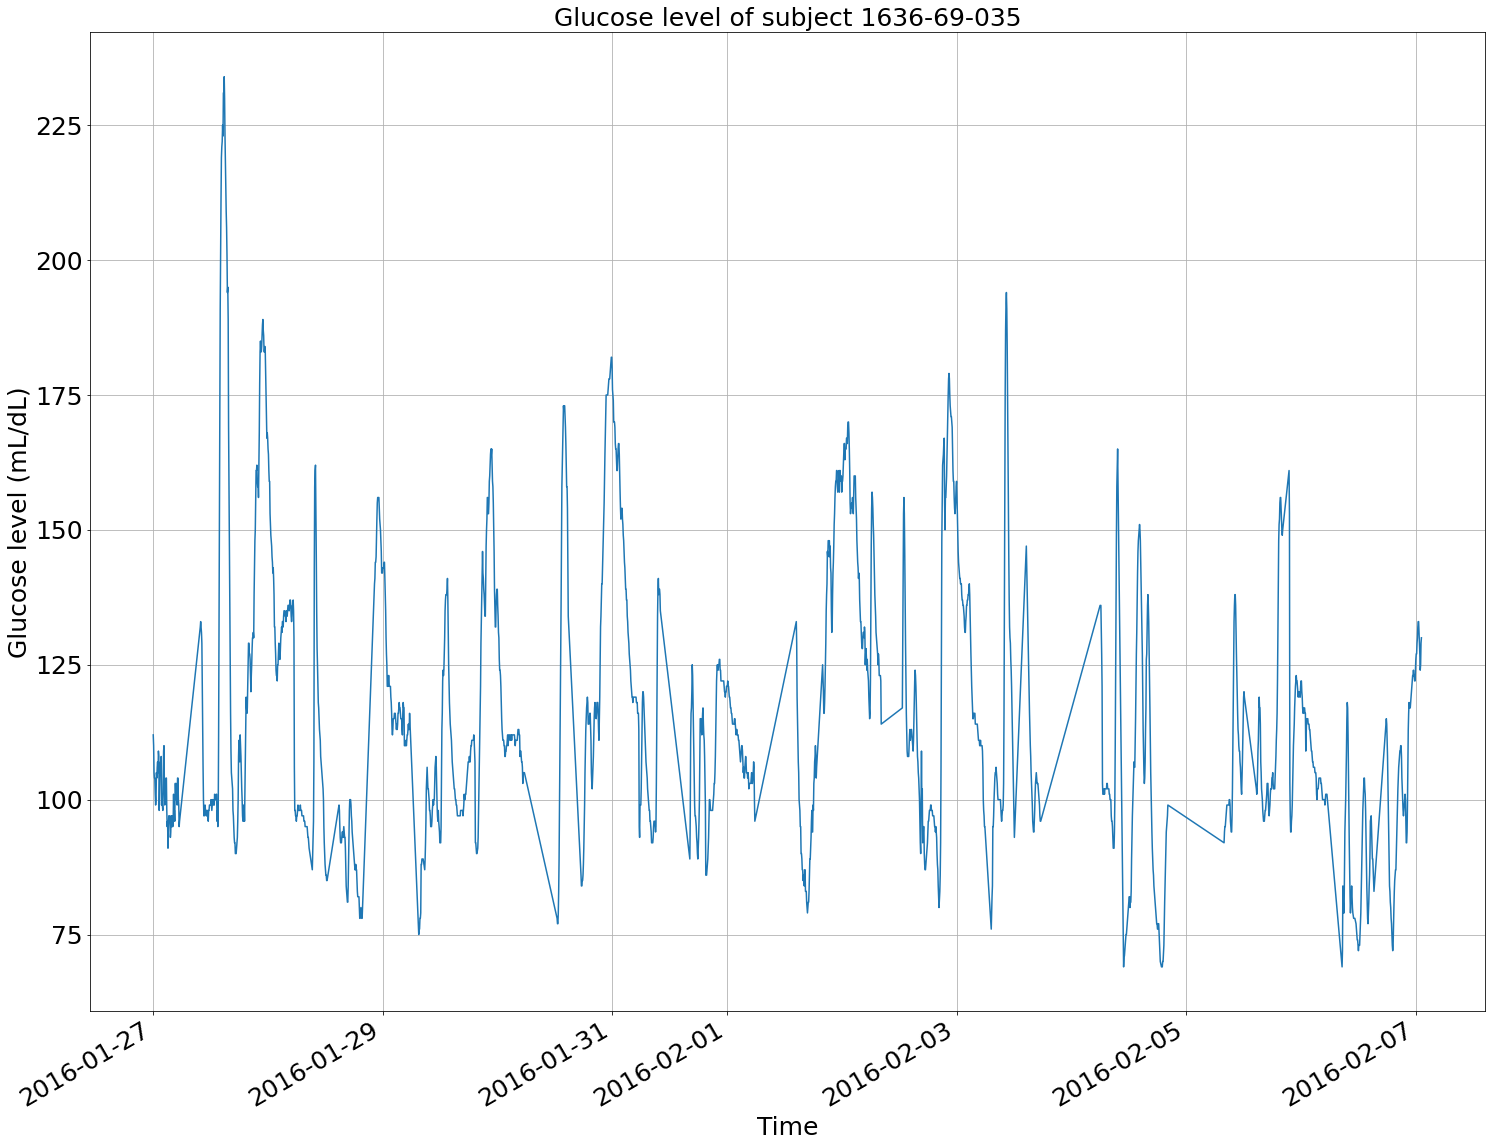

In [6]:
# Visualize one subject
subj_plot = '1636-69-035'
glucose_subj_plot = glucose_dict[subj_plot]
timestamp = glucose_subj_plot['timestamp']
glucose_value = glucose_subj_plot['glucose_value']
font_size = 25
fig = plt.figure(figsize=(25, 20))

ax = fig.add_subplot(1, 1, 1)
plt.plot(timestamp, glucose_value)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_title('Glucose level of subject ' + subj_plot, fontsize = font_size)
ax.set_xlabel('Time', fontsize = font_size)
ax.set_ylabel('Glucose level (mL/dL)', fontsize = font_size)
plt.gcf().autofmt_xdate()
plt.grid()

In [7]:
# Display patient info
patient_info.head()

,userID,Age,BMI,A1C,FBG,ogtt.2hr,insulin,hs.CRP,Tchol,Trg,...,freq_low,freq_moderate,freq_severe,glucotype,Height,Weight,Insulin_rate_dd,perc_cgm_prediabetic_range,perc_cgm_diabetic_range,SSPG
0,1636-69-001,59.0,21.7,6.7,109.0,205.0,9.0,0.3,204.0,135.0,...,0.147059,0.369748,0.483193,severe,176.3,68.0,0.10150,0.190404,0.026211,91.0
1,1636-69-026,67.0,28.9,6.2,97.0,152.0,7.0,1.2,208.0,76.0,...,0.004202,0.289916,0.705882,severe,157.5,76.0,NaN,0.083120,0.000000,133.0
2,1636-69-028,50.0,27.3,5.2,91.0,121.0,4.0,4.4,127.0,25.0,...,0.008403,0.424370,0.567227,severe,NaN,NaN,NaN,0.071429,0.001544,75.0
3,1636-69-032,59.0,25.0,5.7,82.0,142.0,5.0,0.2,224.0,138.0,...,0.021008,0.491597,0.487395,moderate,169.4,68.2,0.01575,0.014764,0.000000,87.0
4,1636-69-035,60.0,28.2,5.5,87.0,118.0,NaN,0.2,224.0,85.0,...,0.029412,0.352941,0.617647,severe,176.5,82.5,0.05642,0.154650,0.005921,160.0


In [8]:
# Classify patients diabetes status based on HbA1C and 2-hr OGTT
# T2DB: HbA1c > 6.5%, fasting blood glucose > 126 mg/dL, or 2-hr OGTT > 200 mg/dL
# Pre-T2DB: 5.7% < HbA1c < 6.5%, fasting blood glucose: 100–125 mg/dL, or 2-hr OGTT: 140–199 mg/dL
patient_diabetes_status = patient_info[['userID', 'A1C', 'ogtt.2hr', 'FBG']]
patient_diabetes_status['T2DB_status'] = 'normal'
diabetes_index = (patient_info['A1C'] > 6.5) | (patient_info['FBG'] > 126) | (patient_info['ogtt.2hr'] > 200)
prediabetes_index = ((patient_info['A1C'] > 5.7) & (patient_info['A1C'] <= 6.5)) \
                    | ((patient_info['FBG'] > 100) & (patient_info['FBG'] < 126)) \
                    | ((patient_info['ogtt.2hr'] > 140) & (patient_info['ogtt.2hr'] < 200))
patient_diabetes_status.loc[prediabetes_index, 'T2DB_status'] = 'prediabetes'
patient_diabetes_status.loc[diabetes_index, 'T2DB_status'] = 'diabetes'
patient_diabetes_status['Monitor_duration_day'] = duration_day
patient_diabetes_status.sort_values(by=['T2DB_status'], inplace=True)
patient_diabetes_status

,userID,A1C,ogtt.2hr,FBG,T2DB_status,Monitor_duration_day
0,1636-69-001,6.7,205.0,109.0,diabetes,423
37,2133-018,6.4,256.0,103.0,diabetes,6
26,2133-004,6.0,NaN,145.0,diabetes,6
11,1636-69-091,6.5,151.0,127.0,diabetes,6
54,2133-039,5.1,240.0,100.0,diabetes,9
27,2133-006,5.3,67.0,80.0,normal,6
55,2133-040,5.2,105.0,86.0,normal,6
29,2133-008,NaN,NaN,NaN,normal,6
30,2133-009,5.2,113.0,84.0,normal,6
31,2133-010,NaN,125.0,91.0,normal,6


In [9]:
# Remove subjects with recording time more than 15 days
subjectID_train = patient_diabetes_status[patient_diabetes_status['Monitor_duration_day']<15]['userID']
t2db_status_train = patient_diabetes_status[patient_diabetes_status['Monitor_duration_day']<15]['T2DB_status']
subject_train = {}
for (subj, t2db_status) in zip(subjectID_train, t2db_status_train):
    subject_train[subj] = t2db_status

n_subj_train = len(subjectID_train)
print('Number of subjects for training: ' + str(n_subj_train))
print('Number of diabetes subjects for training: ' + str(sum(t2db_status_train == 'diabetes')))
print('Number of pre-diabetes subjects for training: ' + str(sum(t2db_status_train == 'prediabetes')))

Number of subjects for training: 49
Number of diabetes subjects for training: 4
Number of pre-diabetes subjects for training: 13


In [10]:
# Make all the time series the same length by cutting the long ones
glucose_dict_trimmed = {}
for subject in subjectID_train:
    # Load the data
    glucose_subj_test = glucose_dict[subject]
    timestamp_norm = glucose_subj_test['timestamp_norm']
    glucose_value = glucose_subj_test['glucose_value']
    
    # Select only those timestamp that is less than the minimum duration
    glucose_dict_trimmed[subject] = {}
    ind_select = (timestamp_norm < min_duration)
    glucose_dict_trimmed[subject]['timestamp_trimmed'] = timestamp_norm[ind_select]
    glucose_dict_trimmed[subject]['glucose_trimmed'] = glucose_value[ind_select]    

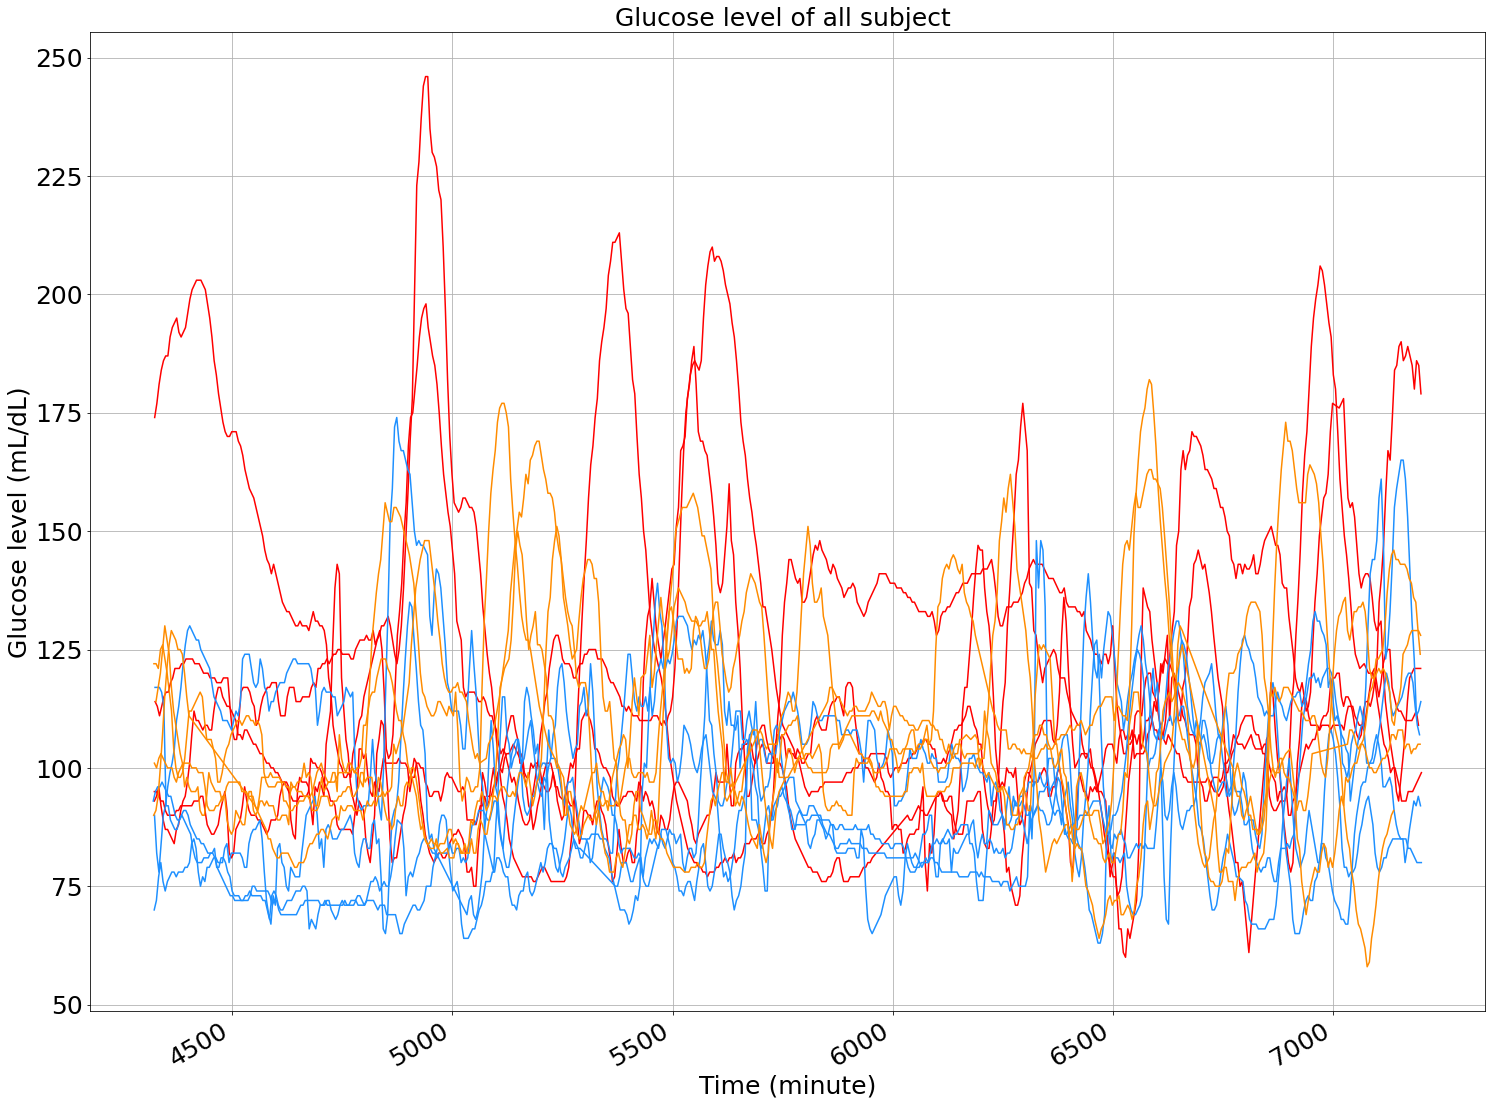

In [87]:
# Plot all subjects according to the T2DB group
font_size = 25
fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(1, 1, 1)
count_normal = 0
count_prediabetes = 0
t_plot_start = 60 * 24 * 3
t_plot_end =  60 * 24 *5

for (subj_plot, t2db_status) in zip(subjectID_train, t2db_status_train):
    glucose_subj_plot = glucose_dict_trimmed[subj_plot]
    timestamp_trimmed = glucose_subj_plot['timestamp_trimmed']
    glucose_trimmed = glucose_subj_plot['glucose_trimmed']
    ind_plot1 = np.logical_and(timestamp_trimmed > t_plot_start, timestamp_trimmed < t_plot_end)


    if t2db_status == 'normal':
        color_plot = 'dodgerblue'
        count_normal = count_normal + 1
        if count_normal > 4:
            continue
    elif t2db_status == 'prediabetes':
        color_plot = 'darkorange'
        count_prediabetes = count_prediabetes + 1
        if count_prediabetes > 4:
            continue        
    elif t2db_status == 'diabetes':
        color_plot = 'red'
        
    plt.plot(timestamp_trimmed[ind_plot1], glucose_trimmed[ind_plot1], color=color_plot)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
               
ax.set_title('Glucose level of all subject ', fontsize = font_size)
ax.set_xlabel('Time (minute)', fontsize = font_size)
ax.set_ylabel('Glucose level (mL/dL)', fontsize = font_size)
plt.gcf().autofmt_xdate()
plt.grid()

In [13]:
# Export the history of all jupyter notebooks
# %history -g -f hist_jupyter_notebook 

# Fit one subject with scikit-learn

In [69]:
# Choose a subject
subj_plot = '1636-69-035'
glucose_subj_plot = glucose_dict_trimmed[subj_plot]
timestamp_trimmed = glucose_subj_plot['timestamp_trimmed']
glucose_trimmed = glucose_subj_plot['glucose_trimmed']

In [70]:
# Fit the model
amp_scale = 20
len_scale = 5 # minute
gpr_kernel_skl = amp_scale * gp.kernels.RBF(length_scale = len_scale)
gpr_model_skl = gp.GaussianProcessRegressor(kernel=gpr_kernel_skl, normalize_y=True)
stime = time.time()
gpr_model_skl.fit(timestamp_trimmed.reshape(-1, 1), glucose_trimmed)
print("Time for GPR fitting: %.3f (second)" % (time.time() - stime))

Time for GPR fitting: 2.965 (second)


In [71]:
# Predict a finer timestamp
t_predict = np.arange(timestamp_trimmed[0], timestamp_trimmed[-1], 1)
glucose_predict_mean_skl, glucose_predict_std_skl = gpr_model_skl.predict(t_predict.reshape(-1, 1), return_std=True)

# Fit one subject with gpflow

In [72]:
# Construct the model
gpr_kernel = gpflow.kernels.RBF(lengthscales=40, variance=50)
gpr_model = gpflow.models.GPR(data = (timestamp_trimmed.reshape(-1, 1), glucose_trimmed.reshape(-1, 1)), 
                              kernel=gpr_kernel, mean_function=gpflow.mean_functions.Constant(np.mean(glucose_trimmed)),
                             noise_variance = 10.0)


In [73]:
# Search hyperparams
stime = time.time()
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    gpr_model.training_loss,
    variables=gpr_model.trainable_variables,
    options=dict(disp=True, maxiter=100))
print("Time for GPR fitting: %.3f (second)" % (time.time() - stime))

Time for GPR fitting: 10.393 (second)


In [74]:
# Predict a finer timestamp
t_predict = np.arange(timestamp_trimmed[0], timestamp_trimmed[-1], 1)
glucose_predict_mean, glucose_predict_var = gpr_model.predict_f(t_predict.reshape(-1, 1))
glucose_predict_mean = np.squeeze(glucose_predict_mean)
glucose_predict_var = np.squeeze(glucose_predict_var)

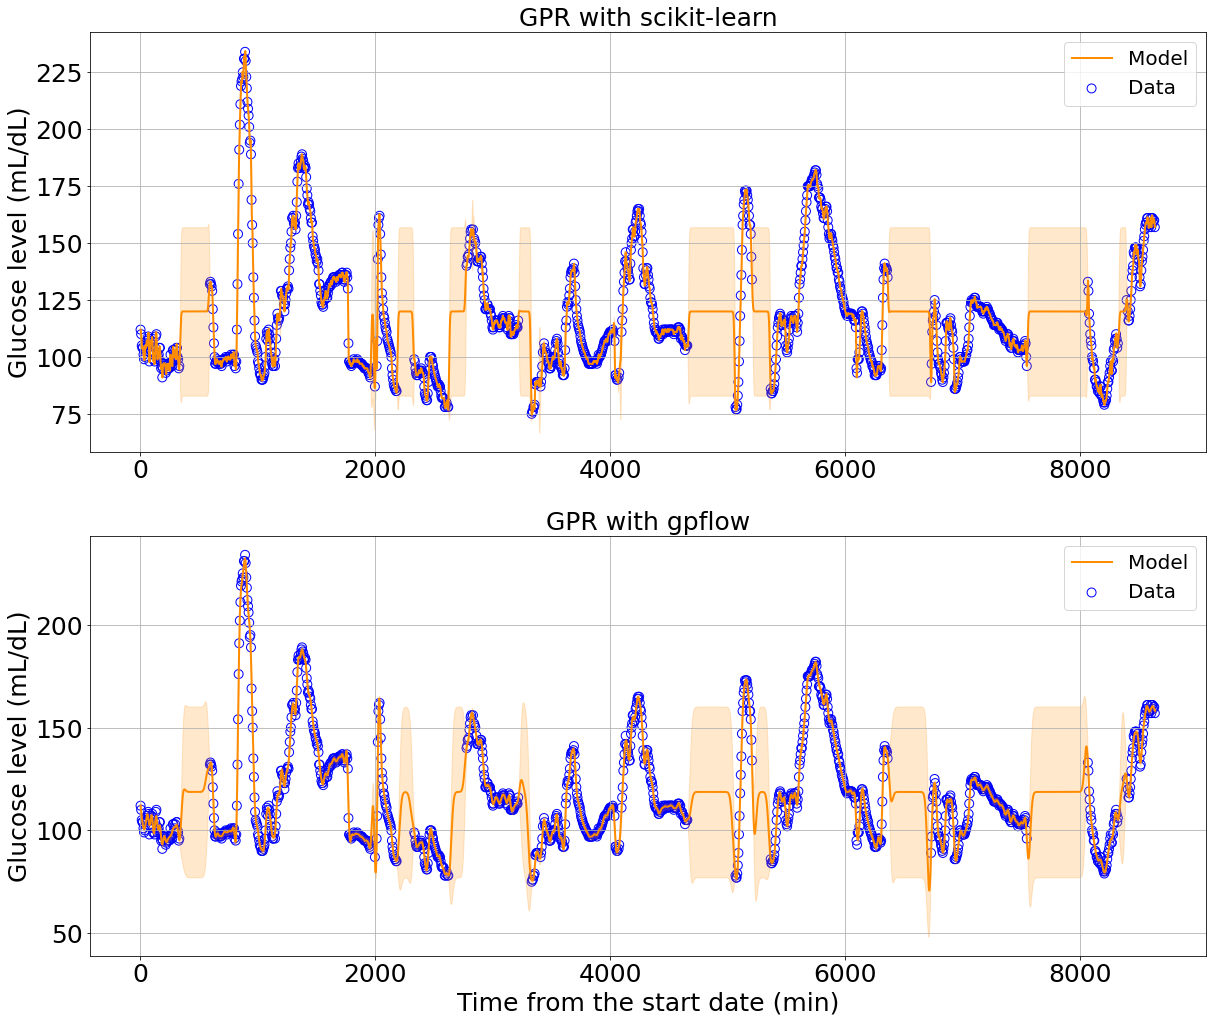

In [80]:
# Plot the prediction
font_size = 25
linewidth = 2
t_plot_start = 60 * 24 * 0
t_plot_end = 60 * 24 * 6
ind_plot1 = np.logical_and(timestamp_trimmed > t_plot_start, timestamp_trimmed < t_plot_end)
ind_plot2 = np.logical_and(t_predict > t_plot_start, t_predict < t_plot_end)

fig = plt.figure(figsize=(20, 17))
ax = fig.add_subplot(2, 1, 1)
plt.scatter(timestamp_trimmed[ind_plot1], glucose_trimmed[ind_plot1], s=80, facecolors='none', edgecolors='b', label='Data')
plt.plot(t_predict[ind_plot2], glucose_predict_mean_skl[ind_plot2], color='darkorange', lw=linewidth, label='Model')
plt.fill_between(t_predict[ind_plot2], glucose_predict_mean_skl[ind_plot2] - 1.96*glucose_predict_std_skl[ind_plot2], 
                 glucose_predict_mean_skl[ind_plot2] + 1.96*glucose_predict_std_skl[ind_plot2], color='darkorange', alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_title('GPR with scikit-learn', fontsize = font_size)
ax.set_ylabel('Glucose level (mL/dL)', fontsize = font_size)
ax.legend(fontsize = font_size-5)
plt.grid()

ax = fig.add_subplot(2, 1, 2)
plt.scatter(timestamp_trimmed[ind_plot1], glucose_trimmed[ind_plot1], s=80, facecolors='none', edgecolors='b', label='Data')
plt.plot(t_predict[ind_plot2], glucose_predict_mean[ind_plot2], color='darkorange', lw=linewidth, label='Model')
plt.fill_between(t_predict[ind_plot2], glucose_predict_mean[ind_plot2] - 1.96*np.sqrt(glucose_predict_var[ind_plot2]), 
                 glucose_predict_mean[ind_plot2] + 1.96*np.sqrt(glucose_predict_var[ind_plot2]), color='darkorange', alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_title('GPR with gpflow', fontsize = font_size)
ax.set_xlabel('Time from the start date (min)', fontsize = font_size)
ax.set_ylabel('Glucose level (mL/dL)', fontsize = font_size)
ax.legend(fontsize = font_size-5)
plt.grid()

In [337]:
gpr_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,(),float64,115.292
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,449.063
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,20.6041
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.92643


# Fit a subset of subjects

In [81]:
# Start fitting
gpr_model_all = {}
count_normal = 0
count_prediabetes = 0
n_subj_normal = 10
n_subj_prediabetes = 10

for (subj_train, t2db_status) in zip(subjectID_train, t2db_status_train):
    # Get the data
    glucose_subj_train = glucose_dict_trimmed[subj_train]
    timestamp_trimmed = glucose_subj_train['timestamp_trimmed']
    glucose_trimmed = glucose_subj_train['glucose_trimmed']

    if t2db_status == 'normal':
        count_normal = count_normal + 1
        if count_normal > n_subj_normal:
            continue
    elif t2db_status == 'prediabetes':
        count_prediabetes = count_prediabetes + 1
        if count_prediabetes > n_subj_prediabetes:
            continue        

    # Construct the model
    gpr_kernel = gpflow.kernels.RBF(lengthscales=10, variance=300)
    gpr_model = gpflow.models.GPR(data = (timestamp_trimmed.reshape(-1, 1), glucose_trimmed.reshape(-1, 1)), kernel=gpr_kernel,
                                   mean_function=gpflow.mean_functions.Constant(np.mean(glucose_trimmed)), noise_variance = 2.0)    
    
    # Search hyperparams
    stime = time.time()
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(gpr_model.training_loss, variables=gpr_model.trainable_variables, options=dict(disp=True, maxiter=100))
    print("Time for GPR fitting of subject {}: {:.2f} (second)".format(subj_train, time.time() - stime))   
    
    # Save the model
    gpr_model_all[subj_train] = gpr_model


Time for GPR fitting: 17.960 (second)
Time for GPR fitting: 25.706 (second)
Time for GPR fitting: 16.578 (second)
Time for GPR fitting: 9.348 (second)
Time for GPR fitting: 18.744 (second)
Time for GPR fitting: 15.075 (second)
Time for GPR fitting: 20.257 (second)
Time for GPR fitting: 13.767 (second)
Time for GPR fitting: 14.652 (second)
Time for GPR fitting: 10.267 (second)
Time for GPR fitting: 17.354 (second)
Time for GPR fitting: 12.158 (second)
Time for GPR fitting: 19.716 (second)
Time for GPR fitting: 14.867 (second)
Time for GPR fitting: 11.482 (second)
Time for GPR fitting: 17.547 (second)
Time for GPR fitting: 17.527 (second)
Time for GPR fitting: 11.116 (second)
Time for GPR fitting: 13.737 (second)
Time for GPR fitting: 14.792 (second)
Time for GPR fitting: 18.644 (second)
Time for GPR fitting: 15.849 (second)
Time for GPR fitting: 20.684 (second)
Time for GPR fitting: 16.284 (second)


In [82]:
# Save the models
# Note: we cannot save the model directly using pickle so here I save the parameter and the model seperately 
# To load the model: loaded_model = tf.saved_model.load(save_dir)
# Then use gpflow.utilities.multiple_assign(model, model_param) to load the params into model
dir_model = os.path.join(dir_data, 'model_gpr')
dir_model_param = os.path.join(dir_model, 'model_param')
dir_model_graph = os.path.join(dir_model, 'model_graph')
os.makedirs(dir_model, exist_ok=True)  
os.makedirs(dir_model_param, exist_ok=True)    
os.makedirs(dir_model_graph, exist_ok=True)    
file_model_param = 'gpr_model_param'
gpr_model_param = {}
for subj in gpr_model_all.keys():
    # Save model param to dict
    gpr_model_param[subj] = gpflow.utilities.read_values(gpr_model_all[subj])
    
#     # Save the model graph
#     model_save = gpr_model_all[subj]
#     model_save.predict_f_compiled = tf.function(model_save.predict_f)
#     dir_model_graph_subj = os.path.join(dir_model_graph, subj)
#     os.makedirs(dir_model_graph_subj, exist_ok=True)    
#     tf.saved_model.save(model_save, dir_model_graph_subj)
    
pickle.dump(gpr_model_param, open(os.path.join(dir_model_param, file_model_param) + '.p', 'wb'))

# Compute similarity score

In [83]:
# Create a list of subjID grouped by T2DB status
subjID_train_unsorted = gpr_model_all.keys()
subjID_train_sorted = []
for subj in subjID_train_unsorted:
    if subject_train[subj] == 'normal':
        subjID_train_sorted.append(subj)
        
for subj in subjID_train_unsorted:
    if subject_train[subj] == 'prediabetes':
        subjID_train_sorted.append(subj)
        
for subj in subjID_train_unsorted:
    if subject_train[subj] == 'diabetes':
        subjID_train_sorted.append(subj)
        
# Loop over all subjects pairs and compute similarity score
stime = time.time()
n_subj = len(gpr_model_all.keys())
similarity_matrix = np.empty((n_subj,n_subj))
similarity_matrix[:] = np.NaN
count = 0
for ind_ref, subj_ref in enumerate(subjID_train_sorted):
    for ind_test, subj_test in enumerate(subjID_train_sorted):
        # Load reference model
        model_ref = gpr_model_all[subj_ref]
        
        # Load test data
        data_test =  glucose_dict_trimmed[subj_test]
        timestamp_norm = data_test['timestamp_trimmed']
        glucose_trimmed = data_test['glucose_trimmed']
        
        # Compute the likelihood
        similarity_matrix[ind_ref, ind_test] = tf.math.reduce_sum(-model_ref.predict_log_density(data=(timestamp_norm.reshape(-1, 1), 
                                                glucose_trimmed.reshape(-1, 1)))) / len(timestamp_norm)
        
print("Time to compute similarity matrix: {:.2f} (second)".format(time.time() - stime))

Time to compute similarity matrix: 352.184 (second)


In [84]:
# Normalize the similarity score according to the reference 
similarity_matrix_norm = np.empty((n_subj,n_subj))
similarity_matrix_norm[:] = np.NaN
for ind_ref, subj_ref in enumerate(gpr_model_all.keys()):
    for ind_test, subj_test in enumerate(gpr_model_all.keys()):
        similarity_matrix_norm[ind_ref, ind_test] = similarity_matrix[ind_ref, ind_ref] \
                                                        / similarity_matrix[ind_ref, ind_test]
# Put the diagonal to nan        
for ind_ref, subj_ref in enumerate(gpr_model_all.keys()):    
    similarity_matrix_norm[ind_ref, ind_ref] = np.NaN

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


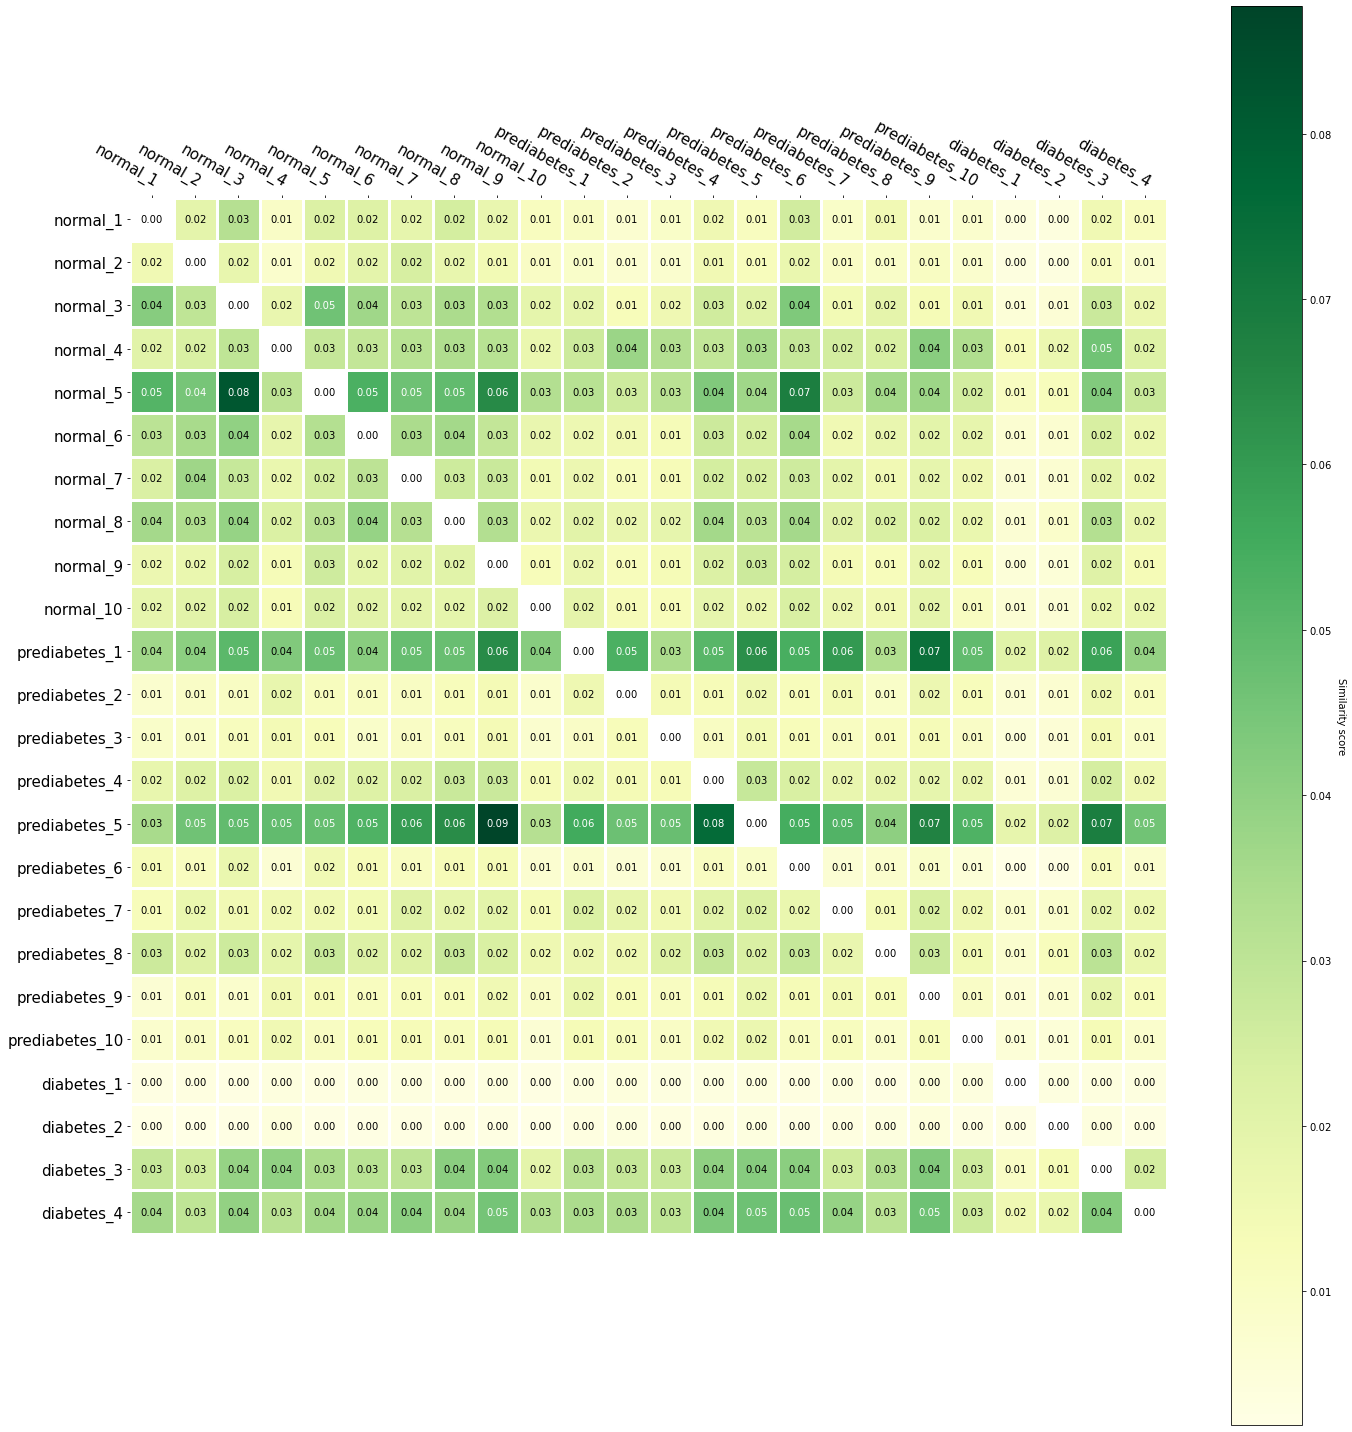

In [85]:
import matplotlib
# Plot the heatmap of similarity score
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, font_size=15, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.tick_params(axis='both', which='major', labelsize=font_size)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}", textcolors=["black", "white"], threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Get the T2DB label for the trained subjects
label_plot = []
count_normal = 0
count_diabetes = 0
count_prediabetes = 0

for subj_ref in subjID_train_sorted:
    if subject_train[subj_ref] == 'normal':
        count_normal = count_normal + 1
        label_plot.append(subject_train[subj_ref] + '_' + str(count_normal))
    elif subject_train[subj_ref] == 'prediabetes':
        count_prediabetes = count_prediabetes + 1
        label_plot.append(subject_train[subj_ref] + '_' + str(count_prediabetes))
    elif subject_train[subj_ref] == 'diabetes':
        count_diabetes = count_diabetes + 1
        label_plot.append(subject_train[subj_ref] + '_' + str(count_diabetes))
        
# Plot the result    
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
im, cbar = heatmap(similarity_matrix_norm, label_plot, label_plot, ax=ax,
                   cmap="YlGn", cbarlabel="Similarity score")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()